# Librerie

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# Immagini + maschere

In [ ]:
path_to_images = tf.keras.utils.get_file("images", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", untar=True)
path_to_annotations = tf.keras.utils.get_file("annotations", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", untar=True)

19177472/19173078 [==============================] - 2s 0us/step


In [ ]:
def create_dataset(p1, p2, dim1, dim2):
  folderT = os.listdir(p1)
  folderT.sort()
  image = []
  label = []
  for i in tqdm(folderT):
    try:
      im = Image.open(p1+i)
      im = np.array(im.resize((dim1, dim2)))
      if im.shape == (dim1, dim2, 3):
        image.append(im)
        im=Image.open(p2+i[:-4]+".png")
        im = np.array(im.resize((dim1, dim2)))
        im -= 1 # le immagini hanno 3 label[1,2,3]-->[0,1,2]
        label.append(im.astype('int'))
    except Image.UnidentifiedImageError:
      continue
  return np.array(image), np.array(label)

In [ ]:
path_img = "/root/.keras/datasets/images/"
path_seg = "/root/.keras/datasets/annotations/trimaps/"
X_train, y_train = create_dataset(path_img, path_seg, 128, 128)
X_train = X_train.astype('float32') / 255.0
y_train = y_train.reshape(-1, 128, 128, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

100%|██████████| 7393/7393 [00:57<00:00, 128.99it/s]


((6640, 128, 128, 3),
 (6640, 128, 128, 1),
 (738, 128, 128, 3),
 (738, 128, 128, 1))

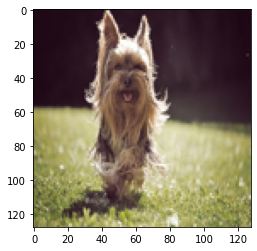

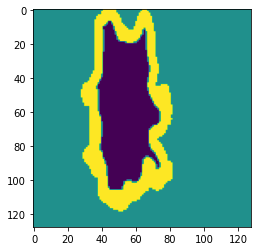

In [ ]:
plt.imshow(X_train[5])
plt.show()
plt.imshow(y_train[5].reshape(128, 128))
plt.show()

# Unet

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
def unet(input_size=(128, 128, 3), label=1):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(2)(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(2)(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(2)(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(2)(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(2)(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(2)(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(2)(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(2)(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)

    loss = 'binary_crossentropy'
    metric = ['accuracy']
    act = 'sigmoid'
    if label != 1:
      loss = tf.keras.losses.SparseCategoricalCrossentropy()
      metric = [keras.metrics.SparseCategoricalAccuracy('accuracy')]
      act = 'softmax'

    conv10 = tf.keras.layers.Conv2D(label, 1, activation=act)(conv9)
    model = tf.keras.models.Model(inputs, conv10)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                  loss=loss,
                  metrics=metric)

    return model

model = unet(label=3)

model.fit(X_train,
          y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_test, y_test),
          verbose=1,
          )

Epoch 1/10
104/104 [==============================] - 54s 519ms/step - loss: 0.8656 - accuracy: 0.6252 - val_loss: 0.7414 - val_accuracy: 0.6931
Epoch 2/10
104/104 [==============================] - 54s 516ms/step - loss: 0.6637 - accuracy: 0.7270 - val_loss: 0.6255 - val_accuracy: 0.7409
Epoch 3/10
104/104 [==============================] - 54s 517ms/step - loss: 0.5904 - accuracy: 0.7607 - val_loss: 0.5165 - val_accuracy: 0.7993
Epoch 4/10
104/104 [==============================] - 54s 516ms/step - loss: 0.4869 - accuracy: 0.8154 - val_loss: 0.4462 - val_accuracy: 0.8286
Epoch 5/10
104/104 [==============================] - 54s 516ms/step - loss: 0.4396 - accuracy: 0.8349 - val_loss: 0.4102 - val_accuracy: 0.8441
Epoch 6/10
104/104 [==============================] - 54s 516ms/step - loss: 0.4148 - accuracy: 0.8442 - val_loss: 0.3896 - val_accuracy: 0.8550
Epoch 7/10
104/104 [==============================] - 54s 517ms/step - loss: 0.3693 - accuracy: 0.8628 - val_loss: 0.3524 - val_ac

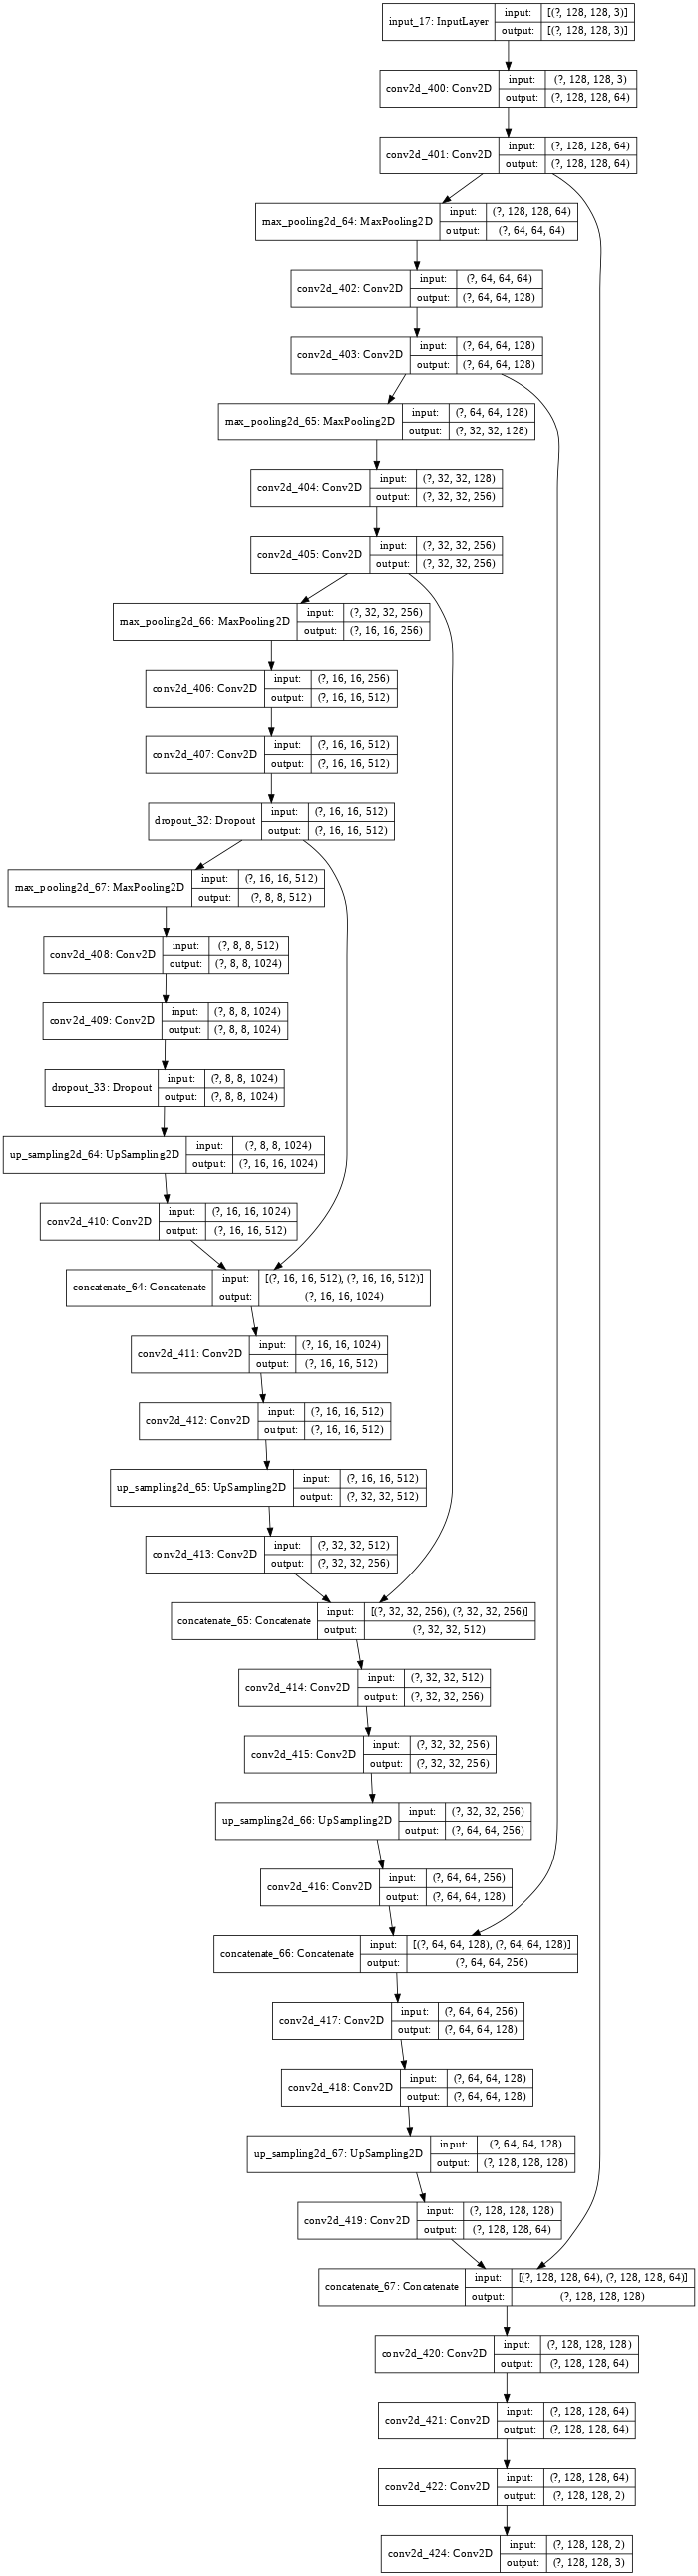

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=58)

# Risultati

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

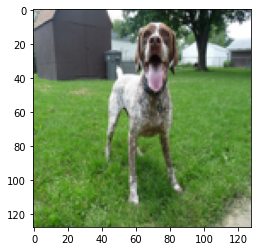

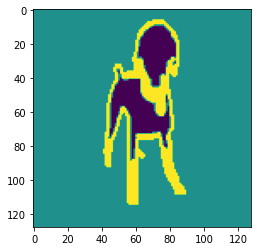

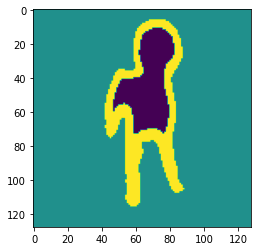

In [ ]:
num_img = 3
plt.imshow(X_test[num_img])
plt.show()
plt.imshow(y_test[num_img].reshape(128, 128))
plt.show()
pred_mask = model.predict(X_test[num_img].reshape(1, 128, 128, 3))
plt.imshow(create_mask(pred_mask).numpy().reshape(128, 128))
plt.show()